Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

In [ ]:
import retinoto_py as fovea

args = fovea.Params(batch_size=1)
args

# testing each network on the validation dataset

In [ ]:
import torch
dataset = 'Imagenet_bbox'
dataset = 'Imagenet_full'
TRAIN_DATA_DIR = args.DATAROOT / dataset / 'train'
VAL_DATA_DIR = args.DATAROOT / dataset / 'val'


In [3]:
from retinoto_py import get_loader
train_loader, class_to_idx, idx_to_class = get_loader(args, TRAIN_DATA_DIR)
val_loader, class_to_idx, idx_to_class = get_loader(args, VAL_DATA_DIR)


In [4]:
# --- 3. Load the Pre-trained ResNet Model ---
from retinoto_py import load_model, count_parameters, count_layers
model = load_model(args)

# Make sure to load a model trained on the same number of classes
num_classes = len(val_loader.dataset.classes)
num_ftrs = model.fc.out_features
print(f'Model has {num_ftrs} output features to final FC layer for {num_classes} classes.')


Model has 1000 output features to final FC layer for 1000 classes.


..................................................
Training model resnet18, file= cached_data/20_resnet18_retrained.pth - image_size=224
Starting learning...
cached_data/20_resnet18_retrained.pth - Epoch 0, i_image 1 : train= loss: 3.0456 / acc : 3.0456 - val= loss : 365334683830765120.0000 / acc : 0.0010 / time:553.1
cached_data/20_resnet18_retrained.pth - Epoch 0, i_image 20019 : train= loss: 38832196494327971840.0000 / acc : 38832196494327971840.0000 - val= loss : 7.4910 / acc : 0.0010 / time:1592.7
cached_data/20_resnet18_retrained.pth - Epoch 0, i_image 40037 : train= loss: 82.4446 / acc : 82.4446 - val= loss : 7.5063 / acc : 0.0010 / time:2622.5
cached_data/20_resnet18_retrained.pth - Epoch 0, i_image 60055 : train= loss: 3.7537 / acc : 3.7537 - val= loss : 7.5175 / acc : 0.0010 / time:3647.5
cached_data/20_resnet18_retrained.pth - Epoch 0, i_image 80073 : train= loss: 3.7522 / acc : 3.7522 - val= loss : 7.4779 / acc : 0.0010 / time:4673.3
cached_data/20_resnet18_retrained.pth - 

KeyboardInterrupt: 

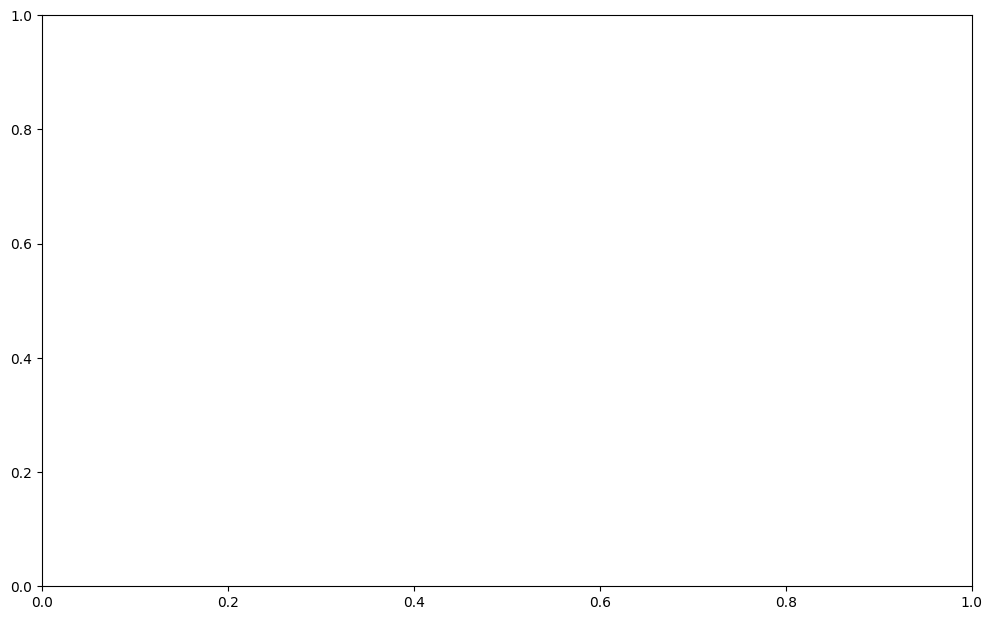

In [5]:
from pathlib import Path
import pandas as pd
import time 
from retinoto_py import train_model 
fig_width, phi = 12, 1.618
import matplotlib.pyplot as plt


print(50*'.')
model_filename = args.data_cache / f'20_{args.model_name}_retrained.pth'
json_filename = args.data_cache / model_filename.name.replace('.pth', '.json')
lock_filename = args.data_cache / model_filename.name.replace('.pth', '.lock')
def touch(fname): open(fname, 'w').close()

df_train = None
should_resume_training = not lock_filename.exists()
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi)) #, subplotpars=subplotpars)

if json_filename.exists():
    print(f"Load JSON from pre-trained resnet {json_filename}")
    df_train = pd.read_json(json_filename, orient='index')
    print(f"{model_filename}: accuracy = {df_train['avg_acc_val'][-5:].mean():.3f}")
    should_resume_training = (df_train['epoch'].max() + 1 < args.num_epochs) and (not lock_filename.exists())

if should_resume_training:
    touch(lock_filename) # as we do a training let's lock it
    # we need to train the model or finish a training that already started
    print(f"Training model {args.model_name}, file= {model_filename} - image_size={args.image_size}")
    start_time = time.time()
    model_retrain, df_train = train_model(args, model=model, train_loader=train_loader, val_loader=val_loader, df_train=df_train, model_filename=model_filename)
    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    print()     

color = 'r'
lw = 1

if not(df_train is None):
    trained_epochs = df_train['epoch'].max() + 1
    if trained_epochs < args.num_epochs:
        print(f"Training in progress with {trained_epochs} ")
    else:
        if lock_filename.exists(): lock_filename.remove()

        x = df_train['total_image'].values
        y = df_train['avg_acc_val'].values

        df_train_roll = df_train.rolling(window=5, min_periods=1, center=False).mean()
        ax = df_train_roll.plot(x='total_image', y='avg_acc', 
                            c=color, ls='dashed', lw=lw,
                            grid=True, ax=ax, label='TRAIN: ' + args.model_name)    
        ax = df_train_roll.plot(x='total_image', y='avg_acc_val', 
                            c=color, lw=lw,
                            grid=True, ax=ax, label='VAL: ' + args.model_name)   

        # the model has been trained, we can remove the lock file     


In [ ]:
lock_filename.exists()

In [ ]:
%rm {lock_filename}